In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
columns = ['date', 'home', 'homeScore', 'away', 'awayScore', 'averageHomeScore', 'averageHomeDefence', 'averageAwayScore', 'averageAwayDefence']
data = pd.read_csv('./drive/MyDrive/Datasets/BasketballScores/clean_games.csv', names=columns)

In [4]:
data

,date,home,homeScore,away,awayScore,averageHomeScore,averageHomeDefence,averageAwayScore,averageAwayDefence
0,2015-11-13,Hawaii,87,Montana State,76,87.000000,76.000000,76.000000,87.000000
1,2015-11-13,Eastern Michigan,70,Vermont,50,70.000000,50.000000,50.000000,70.000000
2,2015-11-13,Yale,70,Fairfield,57,70.000000,57.000000,57.000000,70.000000
3,2015-11-13,Central Michigan,89,Jacksonville State,83,89.000000,83.000000,83.000000,89.000000
4,2015-11-13,Iowa State,68,Colorado,62,68.000000,62.000000,62.000000,68.000000
...,...,...,...,...,...,...,...,...,...
20155,2019-03-21,Charleston Southern,68,Florida Atlantic,66,80.058824,63.529412,67.777778,70.666667
20156,2019-03-21,Louisiana-Monroe,87,Kent State,77,85.062500,74.562500,71.466667,75.200000
20157,2019-03-21,Cal State Fullerton,58,Cal State Bakersfield,66,71.437500,65.500000,67.388889,72.666667
20158,2019-03-22,Southern Utah,80,Drake,73,80.666667,72.333333,70.200000,70.066667


In [5]:
# create results from home - defence
labels = data['averageHomeScore'] - data['averageHomeDefence']

In [6]:
labels

0        11.000000
1        20.000000
2        13.000000
3         6.000000
4         6.000000
           ...    
20155    16.529412
20156    10.500000
20157     5.937500
20158     8.333333
20159    10.476190
Length: 20160, dtype: float64

In [7]:
# SPLIT DATA INTO TRAIN/TEST/VALIDATE

# remove columns we wont use - date team names and scores?
data.drop(['date', 'home', 'homeScore', 'away', 'awayScore'], axis=1, inplace=True)
data.head(5)

,averageHomeScore,averageHomeDefence,averageAwayScore,averageAwayDefence
0,87.0,76.0,76.0,87.0
1,70.0,50.0,50.0,70.0
2,70.0,57.0,57.0,70.0
3,89.0,83.0,83.0,89.0
4,68.0,62.0,62.0,68.0


In [8]:
data['results'] = labels
data

,averageHomeScore,averageHomeDefence,averageAwayScore,averageAwayDefence,results
0,87.000000,76.000000,76.000000,87.000000,11.000000
1,70.000000,50.000000,50.000000,70.000000,20.000000
2,70.000000,57.000000,57.000000,70.000000,13.000000
3,89.000000,83.000000,83.000000,89.000000,6.000000
4,68.000000,62.000000,62.000000,68.000000,6.000000
...,...,...,...,...,...
20155,80.058824,63.529412,67.777778,70.666667,16.529412
20156,85.062500,74.562500,71.466667,75.200000,10.500000
20157,71.437500,65.500000,67.388889,72.666667,5.937500
20158,80.666667,72.333333,70.200000,70.066667,8.333333


In [9]:
# randomly split train 70, test 30
train = data.sample(frac=0.7, random_state=0)
# test set is just the data - train set
test = data.drop(train.index)

print('Training set size: {}'.format(len(train)))
print('Test set size: {}'.format(len(test)))

Training set size: 14112
Test set size: 6048


In [10]:
# create corresponding labels
train_labels = train.pop('results')
test_labels = test.pop('results')

In [11]:
# double check
print('Training label size: {}'.format(len(train_labels)))
print('Test label size: {}'.format(len(test_labels)))

Training label size: 14112
Test label size: 6048


In [12]:
# normalise data (X-u/sd)

# normalise training set
mean = train.mean(axis=0)
std = train.std(axis=0)
train_data = (train - mean)/std

# normalise test set
test_data = (test - mean)/std

In [13]:
train_data

,averageHomeScore,averageHomeDefence,averageAwayScore,averageAwayDefence
5951,0.463526,-0.567488,-0.108204,0.659785
15481,-1.818566,-0.045032,0.682442,0.725867
16660,1.889523,0.348884,0.335668,-0.556114
4896,-0.543132,-0.328374,-0.998081,1.066440
12061,0.537168,-0.322092,-0.274656,-0.080327
...,...,...,...,...
19703,-0.570093,0.108158,-0.774011,0.428500
14487,-0.468473,-0.451387,1.375992,0.329378
1891,0.638976,0.514743,-0.465767,0.292666
13716,0.263190,0.709628,0.212370,-0.162562


In [14]:
def create_model():
  """
  Create a sequential Neural Network with 1 input layer, 1 hidden layer and 1 output layer.

  Each dense layer has 32 neurons aside from the final output layer which has 1.

  :return model: Returns the generated model.
  """
  model = keras.models.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=[4]),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
  ])

  # set loss function
  loss = keras.losses.MeanSquaredError()

  # set optimizer
  opt = keras.optimizers.RMSprop()

  # set metrics for evaluation
  metrics = [
             keras.metrics.MeanAbsoluteError(),
             keras.metrics.Accuracy(),
             keras.metrics.MeanSquaredError()
  ]

  # compile model
  model.compile(loss=loss, optimizer=opt, metrics=metrics)

  return model

In [15]:
# simulate overfit model
overfit_model = create_model()

In [16]:
# train model
history = overfit_model.fit(train_data, train_labels, epochs=1000, validation_split=0.2, verbose=False)

In [17]:
# check results
# convert output to df
hist = pd.DataFrame(history.history)

# make epoch column and set to idx
hist['epoch'] = history.epoch
hist

,loss,mean_absolute_error,accuracy,mean_squared_error,val_loss,val_mean_absolute_error,val_accuracy,val_mean_squared_error,epoch
0,45.468174,4.429629,0.000000,45.468174,2.108845,0.899653,0.000000,2.108845,0
1,1.016106,0.574596,0.000000,1.016106,0.283167,0.358632,0.000000,0.283167,1
2,0.195926,0.284427,0.000000,0.195926,0.069174,0.191952,0.000000,0.069174,2
3,0.068530,0.182753,0.000000,0.068530,0.045319,0.165160,0.000000,0.045319,3
4,0.043857,0.149158,0.000000,0.043857,0.021078,0.108113,0.000000,0.021078,4
...,...,...,...,...,...,...,...,...,...
995,0.002236,0.028789,0.000000,0.002236,0.000252,0.013372,0.000354,0.000252,995
996,0.002229,0.028879,0.000089,0.002229,0.019088,0.107878,0.000000,0.019088,996
997,0.002313,0.028578,0.000089,0.002313,0.000942,0.023092,0.000000,0.000942,997
998,0.002247,0.028141,0.000000,0.002247,0.002155,0.039619,0.000000,0.002155,998


In [19]:
# compare with test set
test_loss, test_mae, test_acc, test_mse = overfit_model.evaluate(test_data, test_labels)

189/189 [==============================] - 0s 1ms/step - loss: 0.0034 - mean_absolute_error: 0.0430 - accuracy: 0.0000e+00 - mean_squared_error: 0.0034


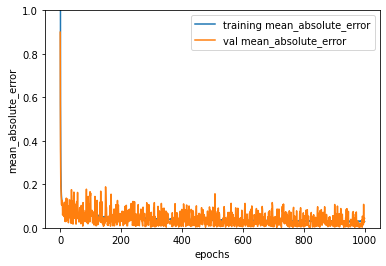

In [20]:
# plot results
def plot_history(history, metric):
  plt.figure()
  plt.xlabel('epochs')
  plt.ylabel(metric)
  plt.plot(history['epoch'], history[metric], label='training '+metric)
  plt.plot(history['epoch'], history['val_'+metric], label='val '+metric)
  plt.legend()
  plt.ylim([0,1])
  plt.show()

plot_history(hist, 'mean_absolute_error')

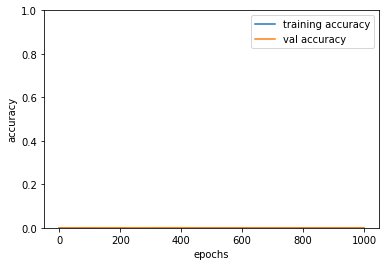

In [21]:
plot_history(hist, 'accuracy')

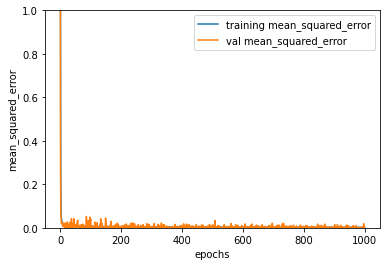

In [22]:
plot_history(hist, 'mean_squared_error')